In [1]:
import folium
from folium.plugins import HeatMap
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from geopy import distance
import lightgbm as lgb
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder

city_names = {1078: ('Казань (GMT+3)', 0),
              22390: ('Самара (GMT+4)', 1),
              22430: ('Саратов (GMT+4)', 1),
              22438: ('Пермь (GMT+5)', 2),
              338: ('Краснодар (GMT +3)', 0),
              22402: ('Уфа (GMT +5)', 2), 
              22406: ('Екатеринбург (GMT +5)', 2), 
              22394: ('Тольятти (GMT +4)', 1)}

In [2]:
train = pd.read_csv('train_with_arrived_error_q90.csv', parse_dates=['OrderedDate', 'ClientCollected', 'GoodArrived', 'ReadyForCollection'])
valid = pd.read_csv('data/validation.csv', parse_dates=['OrderedDate'])
test = pd.read_csv('data/test.csv', parse_dates=['OrderedDate'])

In [3]:
print(f'train shape: {train.shape}')
print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')

train shape: (832718, 23)
valid shape: (101354, 23)
test shape: (89938, 11)


In [4]:
print(f'train shape: {train.shape}')
print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')

train shape: (832718, 23)
valid shape: (101354, 23)
test shape: (89938, 11)


In [5]:
def feats_generator(df):
    add_hour = pd.to_timedelta(df.main_id_locality.apply(lambda x: city_names[x][1]), unit='hours')
    df['OrderedDate'] = df['OrderedDate'] + add_hour
    
    df['dow'] = df['OrderedDate'].dt.dayofweek
    df['hour'] = df['OrderedDate'].dt.hour
    df['date'] = df['OrderedDate'].dt.date
    df['day'] = df['OrderedDate'].dt.day
    
    df['city_id'] = city_encoder.transform(df['main_id_locality'])
    df['center_dist_from'] = df.apply(lambda r: get_distance(r['latitude'], r['longitude'], 
                                                             r['center_latitude'], r['center_longitude']), axis=1)
    df['center_dist_to'] = df.apply(lambda r: get_distance(r['del_latitude'], r['del_longitude'], 
                                                             r['center_latitude'], r['center_longitude']), axis=1)
    df['speed'] = df['EDA'] / df['ETA'] * 1000
    
    return df

def get_distance(latitude, longitude, del_latitude, del_longitude):
    """
    Get distance from start and destination coordinates.
    :param latitude: latitude coord
    :param longitude: longitude coord
    :param del_latitude: destination latitude coord
    :param del_longitude: destination longitude coord
    :return: distance in km
    """
    coord = (latitude, longitude)
    del_coord = (del_latitude, del_longitude)
    return distance.geodesic(coord, del_coord).km

def mape(y_true, y_pred):
    """
    MAPE metric eval.
    :param y_true:
    :param y_pred:
    :return: MAPE
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
city_encoder = LabelEncoder()
city_encoder.fit(train['main_id_locality'])

train = feats_generator(train)
valid = feats_generator(valid)
test = feats_generator(test)

In [8]:
train['target_ratio'] = train['RTA'] / train['ETA']
valid['target_ratio'] = valid['RTA'] / valid['ETA']

train['target_diff'] = train['RTA'] - train['ETA']
valid['target_diff'] = valid['RTA'] - valid['ETA']

In [9]:
feats = ['dow', 
         'hour', 
         'city_id',
         'ETA', 
         'center_dist_from', 
         'center_dist_to', 
         'EDA', 
         'speed']

target = 'target_ratio'

In [10]:
models = dict()

In [11]:
for city_id, train_city in tqdm(train.groupby('main_id_locality')):
    X = train_city[feats]
    y = train_city[target]
    
    valid_city = valid[valid.main_id_locality == city_id]
    valid_X = valid_city[feats]
    valid_y = valid_city['RTA']
    
    model = CatBoostRegressor(loss_function='MAE')
    model.fit(X=X, y=y, cat_features=[0, 1, 2], verbose=False)
    models[city_id] = model
    
    valid_pred = model.predict(valid_X)
    valid_pred = valid_pred * valid_city['ETA']

    # loss MAE, target_ratio
    print(city_id, mape(valid_y, valid_pred))

1078 14.919580984276426
22390 17.1373782332067
22430 15.114542375845877
22438 16.752894986540944



In [12]:
for city_id, model in models.items():
    test_city = test[test.main_id_locality == city_id]
    test_X = test_city[feats]
    test.loc[test.main_id_locality == city_id, 'Prediction'] = model.predict(test_X) * test_city['ETA']

In [13]:
test.index.rename('id', inplace=True)

In [14]:
test['Prediction'].to_csv('results/submit_catboost_mae_ratio_city_without_sffx.csv')

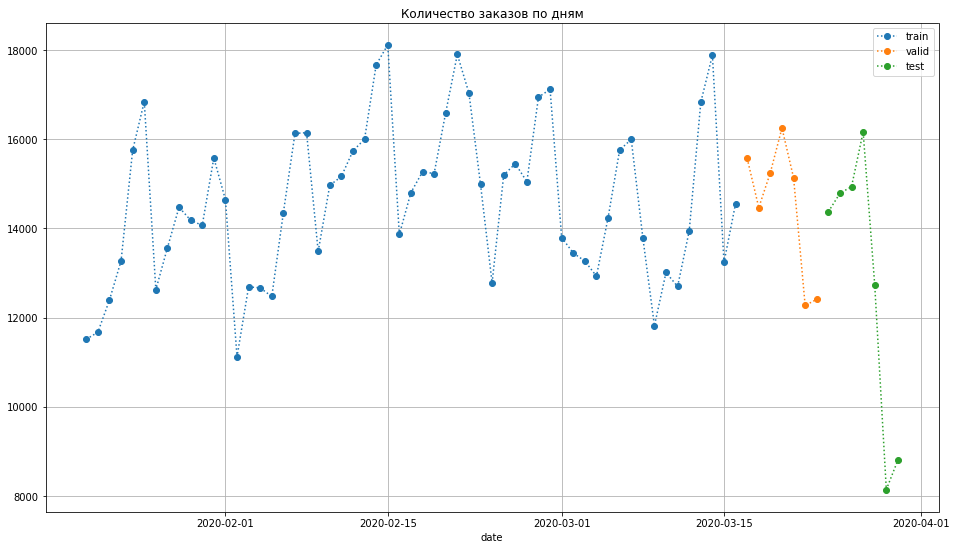

In [14]:
train.groupby('date').size().plot(figsize=(16,9), grid=True, label='train', linestyle=':', marker='o')
valid.groupby('date').size().plot(figsize=(16,9), grid=True, label='valid', linestyle=':', marker='o')
test.groupby('date').size().plot(figsize=(16,9), grid=True, label='test', linestyle=':', marker='o')

plt.title('Количество заказов по дням')
plt.legend()

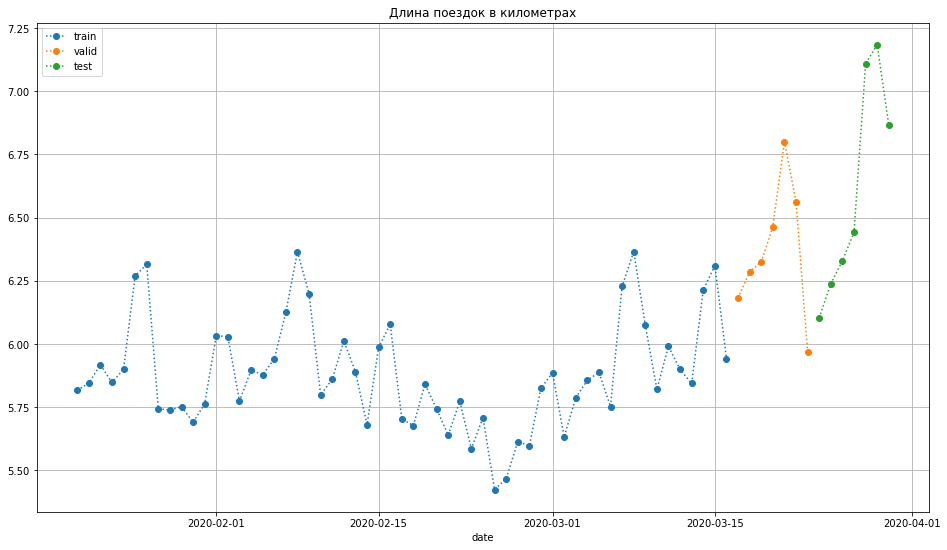

In [13]:
train.groupby('date')['EDA'].mean().plot(figsize=(16,9), grid=True, label='train', linestyle=':', marker='o')
valid.groupby('date')['EDA'].mean().plot(figsize=(16,9), grid=True, label='valid', linestyle=':', marker='o')
test.groupby('date')['EDA'].mean().plot(figsize=(16,9), grid=True, label='test', linestyle=':', marker='o')

plt.title('Длина поездок в километрах')
plt.legend()

plt.savefig('results/eda.png', bbox_inches='tight')

In [20]:
models

{1078: <catboost.core.CatBoostRegressor at 0x14ed23908>,
 22390: <catboost.core.CatBoostRegressor at 0x14ed230b8>,
 22430: <catboost.core.CatBoostRegressor at 0x13ed606a0>,
 22438: <catboost.core.CatBoostRegressor at 0x13c973128>}

In [30]:
for _, model in models.items():
    fi = dict(zip(feats, model.feature_importances_))
    print(fi)
    print()

{'dow': 14.190992095741993, 'hour': 32.26761418239727, 'city_id': 0.0, 'ETA': 25.684516980456536, 'center_dist_from': 8.568317845947734, 'center_dist_to': 8.567742512111815, 'EDA': 2.3750729221464266, 'speed': 8.345743461198278}

{'dow': 12.769029171895522, 'hour': 27.698644368998536, 'city_id': 0.0, 'ETA': 20.507284807254706, 'center_dist_from': 13.931931778927371, 'center_dist_to': 14.006056851943608, 'EDA': 2.4735644843734286, 'speed': 8.613488536606823}

{'dow': 10.324159403261877, 'hour': 23.376370437328614, 'city_id': 0.0, 'ETA': 26.68184394527617, 'center_dist_from': 14.39888141362371, 'center_dist_to': 13.285995900908695, 'EDA': 2.996146233399213, 'speed': 8.936602666201722}

{'dow': 15.904696441613002, 'hour': 27.39699672452056, 'city_id': 0.0, 'ETA': 23.915969857110976, 'center_dist_from': 9.85627353888801, 'center_dist_to': 10.579875794796736, 'EDA': 1.7676236125762448, 'speed': 10.578564030494496}

